# tSNE

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 14 15:43:21 2019

@author: kai
"""

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
from controls_main import RunInfo
from rowwise_neuron_curves_controls import X_data

specify which model, run config etc

In [3]:
modelinfo = dict({'type': 'S',
            'base': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272',
            'name': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1',
            'nlayers': 8,
            'max_act': 14,
            'control': False,
            'cmap': 'Blues_r',
            'color': 'C0',
            'control_cmap': 'Purples_r'})

runinfo = RunInfo({'expid': 102, #internal experiment id
                   'datafraction': 0.5,
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 0,
                   'model_experiment_id': 4, #as per Pranav's model generation
                   'basefolder' : '/mnt/data/random_controls/',
                   'orientation' : 'hor',
                   'height' : 'all'
            })

function declarations

In [4]:
def mytsne(X):
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(X)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    print(f'Total explained variance: {sum(pca.explained_variance_ratio_)}')

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(pca_result)
    
    df = dict()
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    
    return tsne, df

perform tSNE run

In [11]:
layer = 7

In [12]:
labels, xyplmvt = X_data('labels', runinfo, datafolder = runinfo.datafolder(modelinfo))

char_labels = ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n',
               'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']

lname = "Layer %d" %layer

print(lname)
l = pickle.load(open(os.path.join(runinfo.datafolder(modelinfo), 'l%d.pkl' %layer), 'rb'))
l = l[xyplmvt]

lx = l.reshape(l.shape[0], -1)

ltsne, ldf = mytsne(lx)

/mnt/data/random_controls/exp102/data/spatial_temporal_4_8-16-16-32_64-64-64-64_5272/spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1
using alternate method for accessing kinvars files by directly accessing needed arrays (pandas causes error)
Layer 7
Explained variation per principal component: [0.09015508 0.06159016 0.0477873  0.04096175 0.0337868  0.03195836
 0.03062562 0.02489921 0.02271504 0.02054185 0.01750086 0.01699338
 0.01514827 0.01451032 0.01355403 0.01247126 0.01225963 0.01145103
 0.01103871 0.0106984  0.01011769 0.009578   0.008707   0.00809308
 0.00783758 0.00755261 0.00732667 0.00701606 0.00661755 0.00645263
 0.0061686  0.00587766 0.00574621 0.00537146 0.00527063 0.00515813
 0.00481058 0.00462665 0.00446875 0.00439069 0.00421496 0.00408783
 0.00397208 0.00382808 0.00361981 0.00353757 0.00342478 0.00328366
 0.00316124 0.00308563]
Total explained variance: 0.7080509443767369
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3945 samples in 0.019s...
[t-SNE] Comput

plotting

In [7]:
alpha = 0.8
name = modelinfo['base']

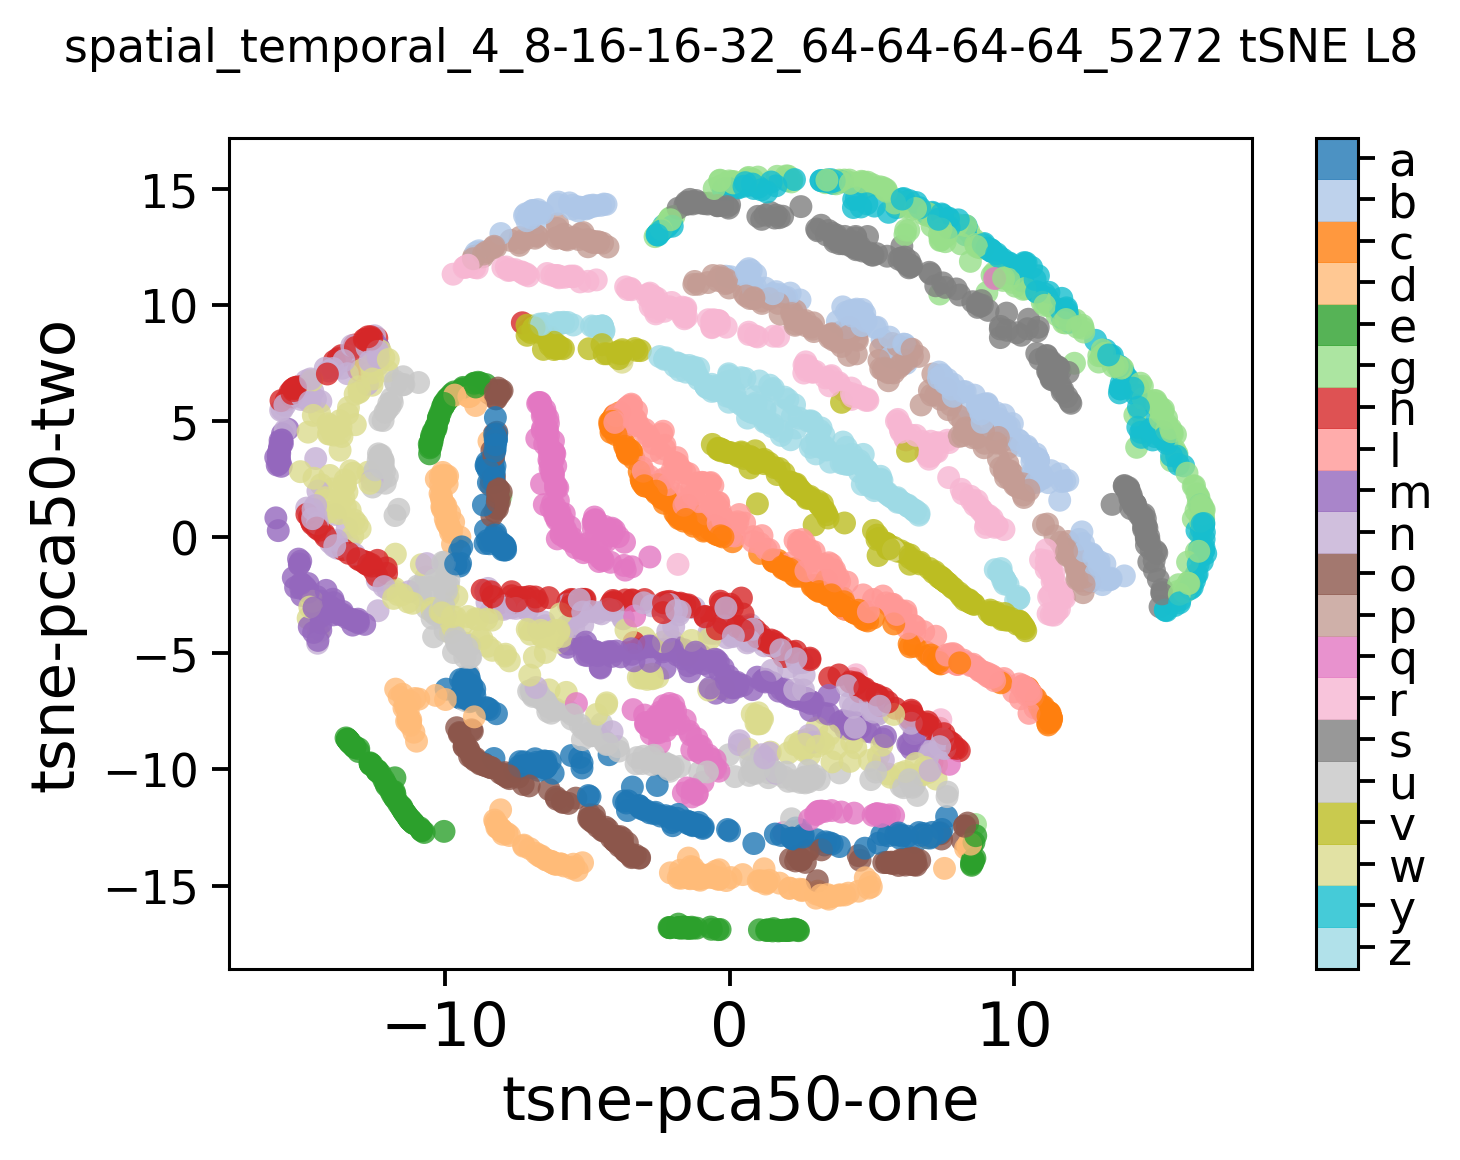

In [14]:
plt.figure(dpi=275)
plt.scatter(
    x = ldf['tsne-2d-one'],
    y = ldf['tsne-2d-two'],
    #s=4,
    edgecolors = 'none',
    c=19 - labels,
    cmap='tab20_r',
    alpha = alpha
)
cb = plt.colorbar()
cb.set_ticks(np.linspace(0.5, 19.5, 21))
cb.set_ticklabels(char_labels[::-1])
plt.title('%s tSNE L%d' %(name, layer + 1))
plt.xlabel('tsne-pca50-one')
plt.ylabel('tsne-pca50-two')
plt.show()